In [305]:
import csv
import os

import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
# %matplotlib tk

# load stuff
dirname = '/home/giovanni/gvi-fusion/results/imu_simulator/tracking_arena_2021-02-03-13-43-38/debug_spline_fitting_to_ref'

traj_from_ref_fn = os.path.join(dirname, 'ref/trajectory.txt')
vel_from_ref_fn = os.path.join(dirname, 'ref/velocity.txt')
imu_from_ref_fn = os.path.join(dirname, 'ref/seq1/simulated_imu_meas.txt')

traj_from_sim_fn = os.path.join(dirname, 'flown_in_sim/trajectory.txt')
vel_from_sim_fn = os.path.join(dirname, 'flown_in_sim/velocity.txt')
imu_from_sim_fn = os.path.join(dirname, 'flown_in_sim/seq1/simulated_imu_meas.txt')

traj_from_ref = np.loadtxt(traj_from_ref_fn)
vel_from_ref = np.loadtxt(vel_from_ref_fn)
imu_from_ref = np.loadtxt(imu_from_ref_fn)

traj_from_sim = np.loadtxt(traj_from_sim_fn)
vel_from_sim = np.loadtxt(vel_from_sim_fn)
imu_from_sim = np.loadtxt(imu_from_sim_fn)

In [306]:
def matrix_diag(A):
    eigs, P = np.linalg.eig(A)
    P_inv = np.linalg.inv(P)
    X = np.dot(P_inv,A)
    D = np.dot(X,P)
    return D

In [307]:
ts_ref = traj_from_ref[:,0] - traj_from_ref[0,0]
ts_sim = traj_from_sim[:,0] - traj_from_sim[0,0]
t_offset = 1.8
ts_sim -= t_offset

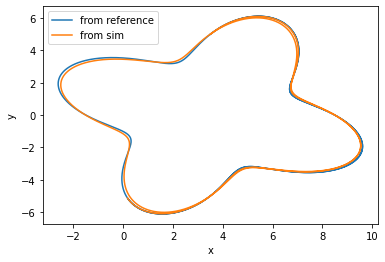

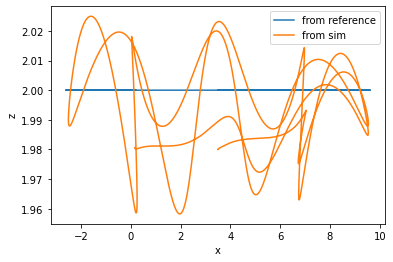

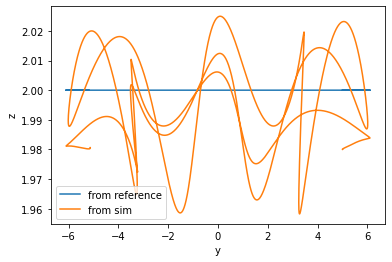

In [308]:
plt.figure('XY traj')
plt.plot(traj_from_ref[:,1], traj_from_ref[:,2], label='from reference')
plt.plot(traj_from_sim[:,1], traj_from_sim[:,2], label='from sim')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.figure('XZ traj')
plt.plot(traj_from_ref[:,1], traj_from_ref[:,3], label='from reference')
plt.plot(traj_from_sim[:,1], traj_from_sim[:,3], label='from sim')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.figure('YZ traj')
plt.plot(traj_from_ref[:,2], traj_from_ref[:,3], label='from reference')
plt.plot(traj_from_sim[:,2], traj_from_sim[:,3], label='from sim')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

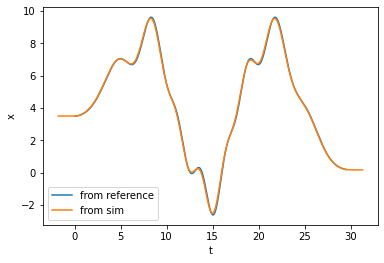

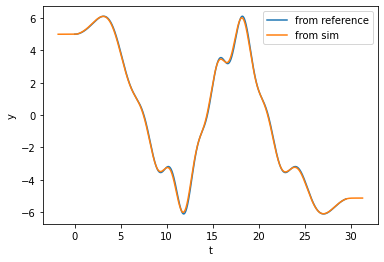

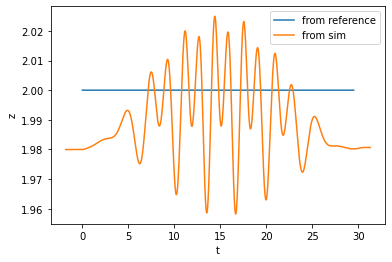

In [309]:
plt.figure('X time')
plt.plot(ts_ref, traj_from_ref[:,1], label='from reference')
plt.plot(ts_sim, traj_from_sim[:,1], label='from sim')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.figure('Y time')
plt.plot(ts_ref, traj_from_ref[:,2], label='from reference')
plt.plot(ts_sim, traj_from_sim[:,2], label='from sim')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

plt.figure('Z time')
plt.plot(ts_ref, traj_from_ref[:,3], label='from reference')
plt.plot(ts_sim, traj_from_sim[:,3], label='from sim')
plt.xlabel('t')
plt.ylabel('z')
plt.legend()

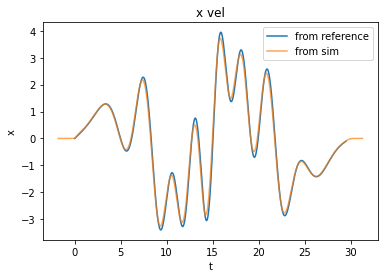

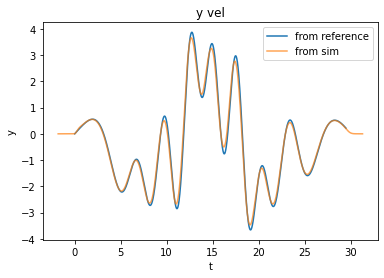

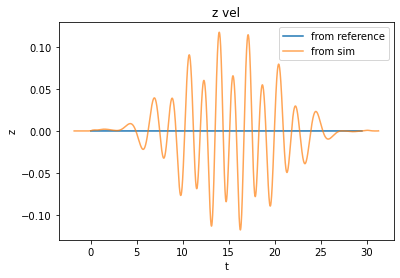

In [310]:
plt.figure('X vel')
plt.plot(ts_ref, vel_from_ref[:,1], label='from reference')
plt.plot(ts_sim, vel_from_sim[:,1], label='from sim', alpha=0.7)
plt.title('x vel')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.figure('y vel')
plt.plot(ts_ref, vel_from_ref[:,2], label='from reference')
plt.plot(ts_sim, vel_from_sim[:,2], label='from sim', alpha=0.7)
plt.title('y vel')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

plt.figure('z vel')
plt.plot(ts_ref, vel_from_ref[:,3], label='from reference')
plt.plot(ts_sim, vel_from_sim[:,3], label='from sim', alpha=0.7)
plt.title('z vel')
plt.xlabel('t')
plt.ylabel('z')

plt.legend()

plt.show()

In [311]:
N = imu_from_ref.shape[0]
M = imu_from_sim.shape[0]
eps = 0.0001

In [312]:
# load data from csv
ref_traj_csv = '/home/giovanni/TLIO/data/tracking_arena_data/29July21/2021-02-03-13-43-38_traj.csv'

with open(ref_traj_csv, 'r') as csvfile:
    traj_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    traj_array = np.array(list(traj_reader))[1:]
    traj_from_csv = traj_array.astype(float)

In [313]:
# add drag force using Faessler's method
mass = 0.875

# load data
vel = []
rot_quat = []
c_thrust = []
g_w = np.array([0.0, 0.0, 9.81])
for t in traj_from_csv:
    qi = np.array([t[4], t[5], t[6], t[7]])
    veli = np.array([t[8], t[9], t[10]])
    W_acc_i = np.array([t[14], t[15], t[16]]) + g_w
    
    c_thrusti = np.linalg.norm(W_acc_i * mass)
    
    vel.append(veli)
    rot_quat.append(qi)
    c_thrust.append(c_thrusti)
    
acc = []
for i in np.arange(0,M,4):
    B_acci = np.array([imu_from_sim[i,4], imu_from_sim[i,5], imu_from_sim[i,6]])
    qi = np.array([traj_from_sim[i,7], traj_from_sim[i,4], traj_from_sim[i,5], traj_from_sim[i,6]])
    Ri = Quaternion(qi).rotation_matrix
    W_acci = np.dot(Ri.T, B_acci) - g_w
    acc.append(W_acci)
                    
n_samples = np.minimum(len(acc), len(vel))

acc = np.asarray(acc)
acc = acc[:n_samples]
vel = np.asarray(vel)
vel = vel[:n_samples]
rot_quat = np.asarray(rot_quat)
rot_quat = rot_quat[:n_samples]
c_thrust = np.asarray(c_thrust)
c_thrust = c_thrust[:n_samples]

# estimate drag coeffs.
A = np.zeros((n_samples, 3))
B = np.zeros((n_samples, 3))

for i in range(n_samples):
    R = Quaternion(rot_quat[i]).rotation_matrix
    
    B[i] = np.dot(R.T, -acc[i] - g_w + (c_thrust[i] / mass) *R[:,2])
    A[i] = np.dot(R.T, vel[i])

# Solve least squares
# Find A such that A @ X = B
X = np.linalg.lstsq(A, B, rcond=None)[0]
D = matrix_diag(X.T)
D = np.real(D)

# coeffs. from paper
#D = np.diag([0.491, 0.236, 0.0])

print('D')
print(D)

acc_faessler = []

for i in range(imu_from_ref.shape[0]):
    assert np.abs(imu_from_ref[i, 0] - traj_from_ref[i, 0]) < eps
    assert np.abs(vel_from_ref[i, 0] - traj_from_ref[i, 0]) < eps
    
    ti = traj_from_ref[i]
    vi = vel_from_ref[i]
    
    R = Quaternion(np.array([ti[7], ti[4], ti[5], ti[6]])).rotation_matrix
    
    B_a_d = np.dot(D, vi[1:])
    
    assert (B_a_d.shape[0] == 3) and (len(B_a_d.shape) == 1)
    
    acc_faessler.append(imu_from_ref[i,4:] - B_a_d)
    
acc_faessler = np.asarray(acc_faessler)

D
[[ 1.01361313e+00 -9.51946886e-17 -1.06286159e-16]
 [ 3.45663870e-16 -2.93248283e-01  5.55111512e-16]
 [ 3.45663870e-16  4.99600361e-16 -2.93248283e-01]]


In [314]:
# add drag force as in rotorS
Ct = 1.56252e-06
Cd = 8.06428e-05
mass = 0.875
e_z = np.array([0., 0., 1.])
g_w = np.array([0.0, 0.0, 9.81])

n_samples = traj_from_csv.shape[0]
Fd = [] # Fdi = [Fd_rot1 (dim = (3,)) , Fd_rot2, Fd_rot3, Fd_rot4]
for t in traj_from_csv:
    vA_i = np.array([t[8], t[9], t[10]])
    u_i = np.array([t[20], t[21], t[22], t[23]])
    w_i = np.sqrt(u_i * (1.0/Ct))
    
    W_acc_i = np.array([t[14], t[15], t[16]]) + g_w
    cthrust = W_acc_i
    e_zB = cthrust * (1/np.linalg.norm(cthrust))
    
    vA_I_perp = vA_i - (vA_i.dot(e_zB)) * e_zB
    
    Fd_i = np.zeros((3,4))
    for j in range(4):
        Fd_i[:,j] = -1.0 * w_i[j] * Cd * vA_I_perp
        
    Fd.append(Fd_i)

# add drag to accel from ref.
# If False we add drag to world acc from .csv
acc_rotorS = imu_from_ref[:, [0,4,5,6]]
acc_rotorS = acc_rotorS[::4, :]

n_samples = np.minimum(n_samples, acc_rotorS.shape[0])
for i in range(n_samples):
    acc_rotorS[i, 1:] += np.sum(Fd[i], axis=1) * (1/mass)
acc_rotorS = np.asarray(acc_rotorS)

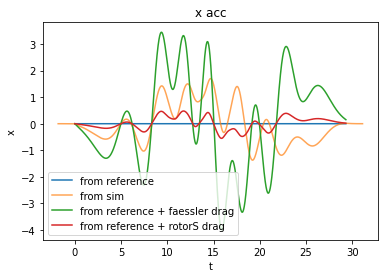

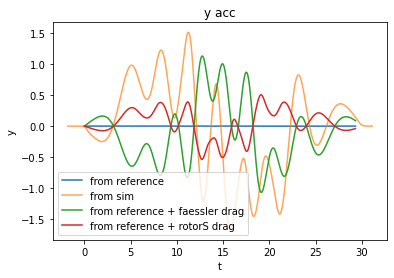

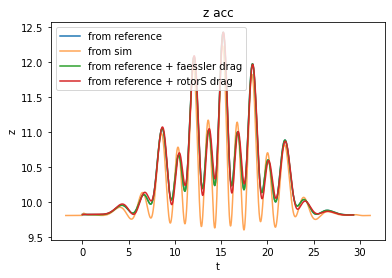

In [315]:
plt.figure('X acc')
plt.plot(ts_ref[:N], imu_from_ref[:,4], label='from reference')
plt.plot(ts_sim[:M], imu_from_sim[:,4], label='from sim', alpha=0.7)
plt.plot(ts_ref[:N], acc_faessler[:,0], label='from reference + faessler drag')
plt.plot(acc_rotorS[:,0], acc_rotorS[:,1], label='from reference + rotorS drag')
plt.title('x acc')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.figure('y acc')
plt.plot(ts_ref[:N], imu_from_ref[:,5], label='from reference')
plt.plot(ts_sim[:M], imu_from_sim[:,5], label='from sim', alpha=0.7)
plt.plot(ts_ref[:N], acc_faessler[:,1], label='from reference + faessler drag')
plt.plot(acc_rotorS[:,0], acc_rotorS[:,2], label='from reference + rotorS drag')
plt.title('y acc')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

plt.figure('z acc')
plt.plot(ts_ref[:N], imu_from_ref[:,6], label='from reference')
plt.plot(ts_sim[:M], imu_from_sim[:,6], label='from sim', alpha=0.7)
plt.plot(ts_ref[:N], acc_faessler[:,2], label='from reference + faessler drag')
plt.plot(acc_rotorS[:,0], acc_rotorS[:,3], label='from reference + rotorS drag')
plt.title('z acc')
plt.xlabel('t')
plt.ylabel('z')

plt.legend()

plt.show()

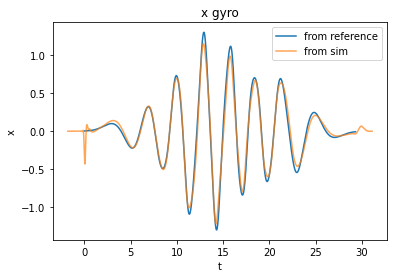

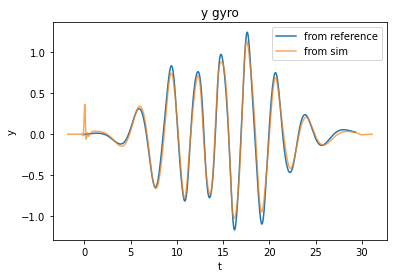

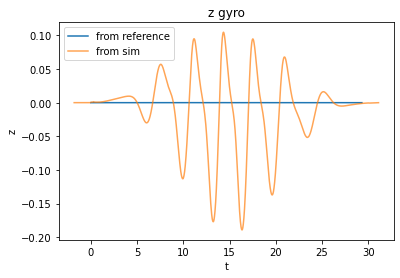

In [316]:
plt.figure('X gyro')
plt.plot(ts_ref[:N], imu_from_ref[:,1], label='from reference')
plt.plot(ts_sim[:M],imu_from_sim[:,1], label='from sim', alpha=0.7)
plt.title('x gyro')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

plt.figure('Y gyro')
plt.plot(ts_ref[:N], imu_from_ref[:,2], label='from reference')
plt.plot(ts_sim[:M], imu_from_sim[:,2], label='from sim', alpha=0.7)
plt.title('y gyro')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()

plt.figure('Z gyro')
plt.plot(ts_ref[:N], imu_from_ref[:,3], label='from reference')
plt.plot(ts_sim[:M], imu_from_sim[:,3], label='from sim', alpha=0.7)
plt.title('z gyro')
plt.xlabel('t')
plt.ylabel('z')

plt.legend()

plt.show()